# Машинное обучение, ФКН ВШЭ

# Практическое задание 7. Бустинговое

## Общая информация

Дата выдачи: 13.12.2022

Мягкий дедлайн: 20.12.2022 23:59 MSK

Жёсткий дедлайн: 20.12.2022 23:59 MSK

## Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

## Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-07-Username.ipynb

Username — ваша фамилия на латинице

## О задании

В этом задании вам предстоит вручную запрограммировать один из самых мощных алгоритмов машинного обучения — бустинг.

In [ ]:
from warnings import filterwarnings

import matplotlib.pyplot as plt
import numpy as np
import scipy
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format='retina'
from scipy.sparse import load_npz
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from collections import defaultdict
import optuna
from catboost import CatBoostRegressor, CatBoostClassifier

sns.set(style='darkgrid')
filterwarnings('ignore')

In [ ]:
x = load_npz('x.npz')
y = np.load('y.npy')

Разделим на обучающую, валидационную и тестовую выборки (`random_state` оставьте равным 1337 для воспроизводимости).

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1337)

x_test, x_valid, y_test, y_valid = train_test_split(x_test, y_test, test_size=0.5, random_state=1337)

x_train.shape, x_valid.shape, x_test.shape

((18825, 169), (2354, 169), (2353, 169))

## Задание 1. Реализация градиентного бустингового (4 балла)

Вам нужно дописать код в файлике `boosting.py`. Для вас уже подготовлен шаблон класса `Boosting`, вы можете менять его по своему усмотрению.

### Инструкции для функций:

#### `__init__`

В `__init__` приходит кучка параметров, распишем что есть что:

 - `base_model_class` - класс базовой модели нашего бустинга
 - `base_model_params` - словарь с гиперпараметрами для базовой модели
 - `n_estimators` - какое количество базовых моделей нужно обучить
 - `learning_rate` - темп обучения, должен быть из полуинтервала $(0, 1]$
 - `subsample` - доля объектов, на которой будет обучаться базовая модель (какую часть составляет бутстрапная выборка от исходной обучающей)
 - `early_stopping_rounds` - число итераций, после которых при отсутствии улучшения качества на валидационной выборке обучение останавливается
 - `plot` - строить ли после обучения всех базовых моделей график с качеством

#### `fit`

В `fit` приходит две выборки, обучающая и валидационная. На обучающей мы обучаем новые базовые модели, на валидационной считаем качество для ранней остановки (если это предусматривают параметры).

Сначала нам нужно сделать какую-то нулевую модель, сделать предсказания для обучающей и валидационной выборок (в шаблоне это нулевая модель, соответственно предсказания это просто `np.zeros`). После этого нужно обучить `n_estimators` базовых моделей (как и на что обучаются базовые модели смотрите в лекциях и семинарах). После каждой обученной базовой модели мы должны обновить текущие предсказания, посчитать ошибку на обучающей и валидационной выборках (используем `loss_fn` для этого), проверить на раннюю остановку.

После всего цикла обучения надо нарисовать график (если `plot`).


#### `fit_new_base_model`

В `fit_new_base_model` приходит обучающая выборка (целиком) и текущие предсказания для неё. Мы должны сгенерировать бутстрап выборку для обучения базовой модели и обучить базовую модель. После обучения модели запускаем поиск оптимальной гаммы, добавляем новую модель и гамму (не забываем про темп обучения) в соответствующие списки.

#### `predict_proba`

В `predict_proba` приходит выборка, нужно предсказать вероятности для неё. Суммируем предсказания базовых моделей на этой выборке (не забываем про гаммы) и накидываем сигмоиду.

In [ ]:
%load_ext autoreload

In [ ]:
%autoreload 2
from boosting import Boosting

### Проверка кода

У автора задания всё учится около одной секунды.

In [ ]:
boosting = Boosting()

%time boosting.fit(x_train, y_train, x_valid, y_valid)

assert len(boosting.models) == boosting.n_estimators
assert len(boosting.gammas) == boosting.n_estimators

assert boosting.predict_proba(x_test).shape == (x_test.shape[0], 2)

print(f'Train ROC-AUC {boosting.score(x_train, y_train):.4f}')
print(f'Valid ROC-AUC {boosting.score(x_valid, y_valid):.4f}')
print(f'Test ROC-AUC {boosting.score(x_test, y_test):.4f}')

# my results:

CPU times: total: 2.03 s
Wall time: 2.21 s
Train ROC-AUC 0.9892
Valid ROC-AUC 0.9115
Test ROC-AUC 0.9099


In [ ]:
# author's results:

CPU times: user 924 ms, sys: 0 ns, total: 924 ms
Wall time: 924 ms
Train ROC-AUC 0.9921
Valid ROC-AUC 0.9172
Test ROC-AUC 0.9110


## Задание 2. Обучение градиентного бустингового (1 балл)

Оцените качество на тестовой выборке вашей имплементации бустинга для различной максимальной глубины решающего дерева в качестве базовой модели. Здесь и далее мы будем использовать метрику ROC-AUC.

Перебирайте максимальную глубину от 1 до 30 с шагом 2 (остальные параметры бустинга стоит оставить равными по умолчанию). Постройте график зависимости качества на обучающей и тестовой выборке в зависимости от глубины.

In [ ]:
results = defaultdict(list)

depths = range(1, 30, 2)
for depth in depths:
    boosting = Boosting(base_model_params={'max_depth': depth}).fit(x_train, y_train, x_valid, y_valid)
    results['train_score'].append(boosting.score(x_train, y_train))
    results['test_score'].append(boosting.score(x_test, y_test))

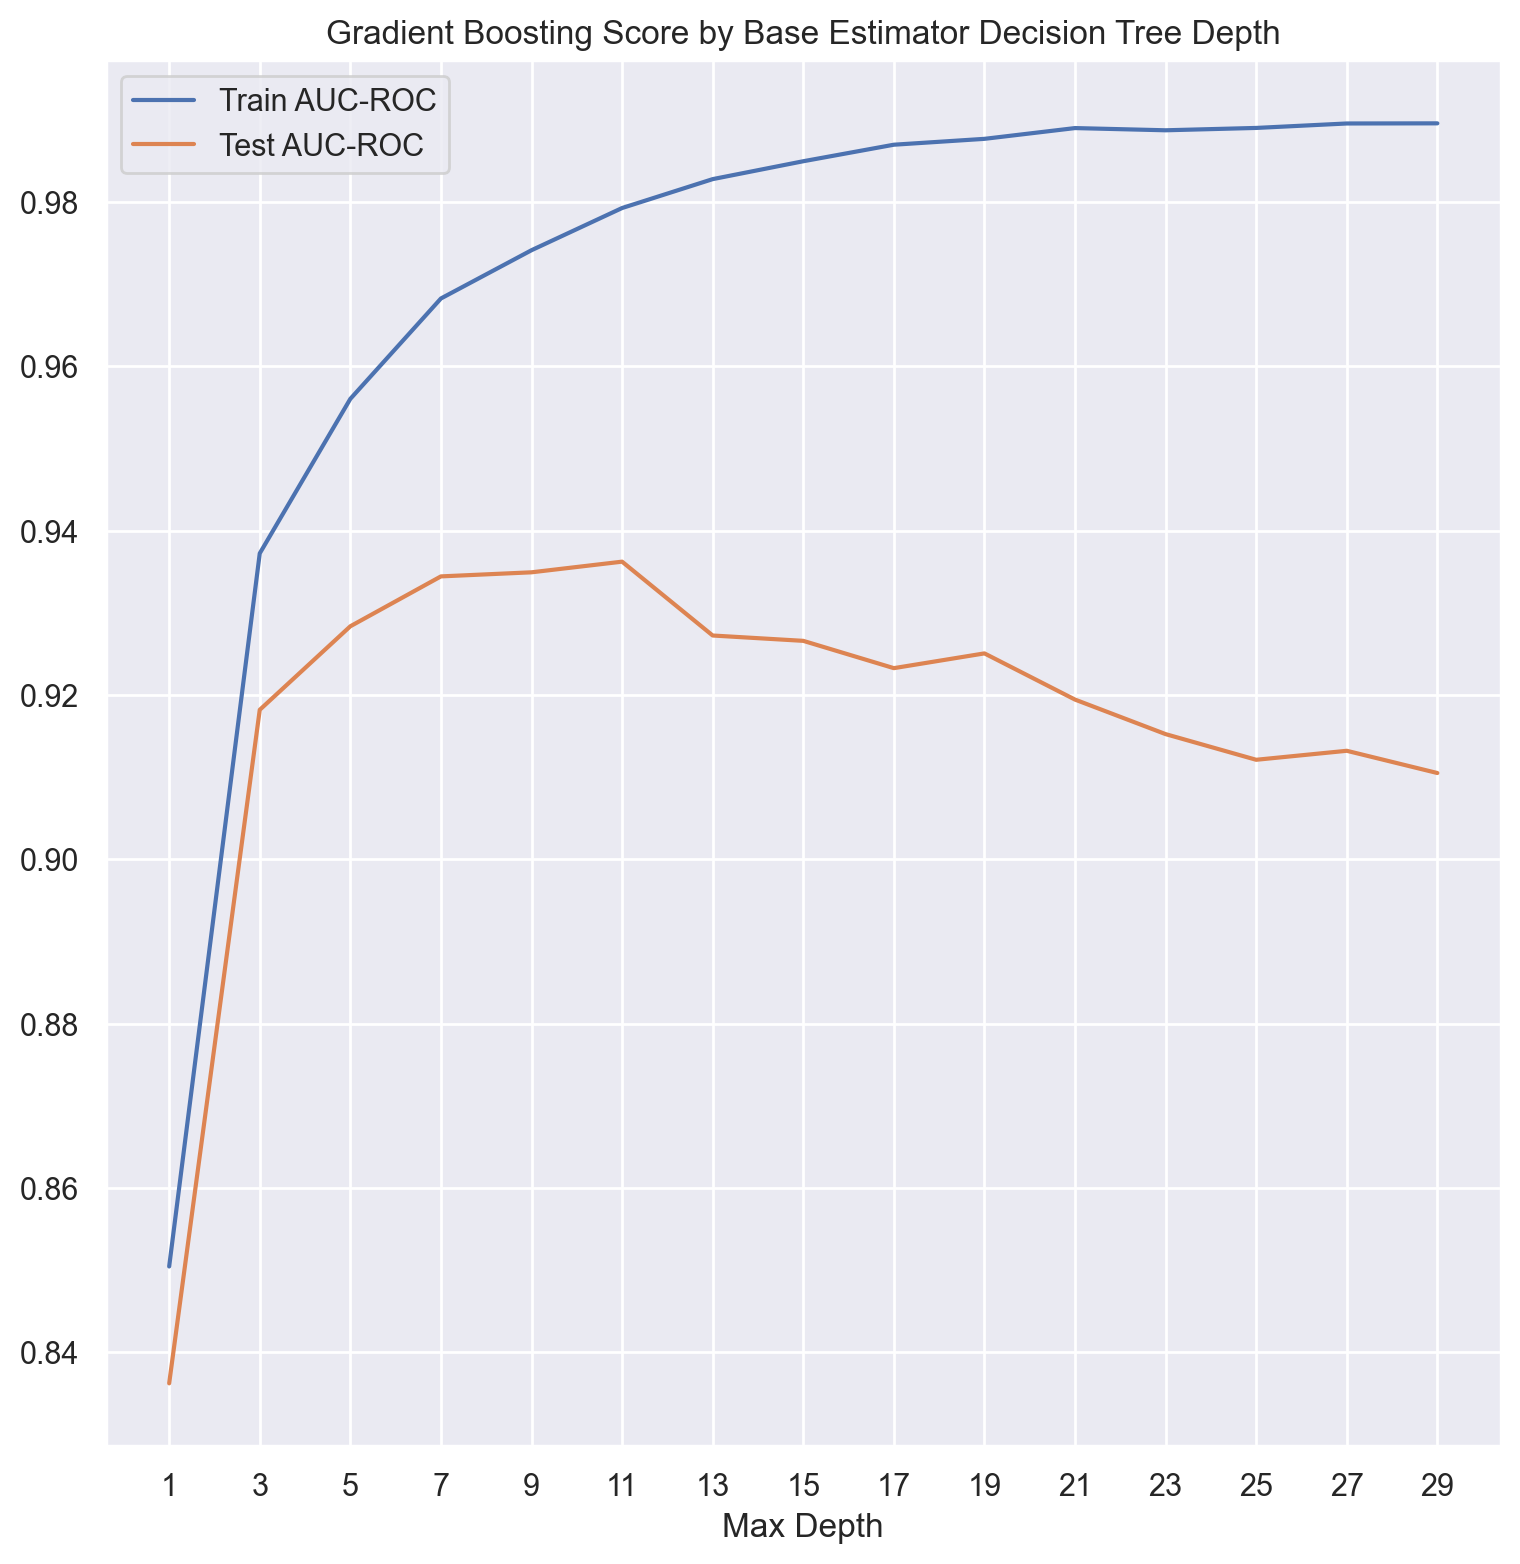

In [ ]:
sns.set(font_scale=1.)
fig, ax = plt.subplots(figsize=(9, 9))
ax.plot(depths, results['train_score'], label='Train AUC-ROC')
ax.plot(depths, results['test_score'], label='Test AUC-ROC')
ax.set_title('Gradient Boosting Score by Base Estimator Decision Tree Depth')
ax.set_xlabel('Max Depth')
ax.legend()
ax.set_xticks(depths)
None

**Какая из моделей имеет лучшее качество? Как вы можете это объяснить?**

Качество на обучающей выборке возрастает при увеличении глубины деревьев, потому что деревья имеют больше возможностей сильнее подогнаться под данные. Это понятно. Что же касается качества на тесте, по графику видно, что у него максимум достигается примерно на глубине около 9-11 (запускал несколько раз, получалось немного по-разному). Это тоже логично, ведь если базовые модели простые, они не могут хорошо приближать необходимые отступы (антиградиент), а если они сложные, то уже даже базовая модель переобучается, и поэтому бустинг тоже переобучается и качество падает.

## Задание 3. Подбираем гиперпараметры и ищем лучшую модель (3 балла)

Подберите по валидационной выборке основные гиперпараметры для вашей модели бустинга. Следует подобрать все основные параметры для самого градиентного бустинга и для самих базовых моделей. Существуют библиотеки для подбора гиперпараметров, попробуйте использовать какую-нибудь из следующих двух - [Hyperopt](https://github.com/hyperopt/hyperopt), [Optuna](https://optuna.org/).

In [ ]:
'''
boosting params:
n_estimators: int = 10,
learning_rate: float = 0.1,
subsample: float = 0.3,
early_stopping_rounds: int = None

tree params:
max_depth=None,
min_samples_split=2,
min_samples_leaf=1
'''
def objective(trial):
    max_depth = trial.suggest_int('max_depth', 1, 30)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 7)
    base_model_params = {'max_depth': max_depth,
                         'min_samples_split': min_samples_split,
                         'min_samples_leaf': min_samples_leaf
                         }
    n_estimators = trial.suggest_int('n_estimators', 10, 110, 10)
    learning_rate = trial.suggest_float('learning_rate', .1, .9, step=.1)
    subsample = trial.suggest_float('subsample', .1, .9, step=.1)
    early_stopping_rounds = trial.suggest_int('early_stopping_rounds', 5, 55, 5)

    model = Boosting(base_model_params, n_estimators=n_estimators, learning_rate=learning_rate, subsample=subsample, early_stopping_rounds=early_stopping_rounds).fit(x_train, y_train, x_valid, y_valid)
    score = model.score(x_valid, y_valid)
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2022-12-20 15:08:43,167] A new study created in memory with name: no-name-3e20105d-80ce-4a17-95bb-63f3b3f31e53
[I 2022-12-20 15:08:48,271] Trial 0 finished with value: 0.9339049977131828 and parameters: {'max_depth': 18, 'min_samples_split': 9, 'min_samples_leaf': 3, 'n_estimators': 40, 'learning_rate': 0.30000000000000004, 'subsample': 0.30000000000000004, 'early_stopping_rounds': 30}. Best is trial 0 with value: 0.9339049977131828.
[I 2022-12-20 15:09:04,766] Trial 1 finished with value: 0.9316960041761353 and parameters: {'max_depth': 19, 'min_samples_split': 6, 'min_samples_leaf': 6, 'n_estimators': 70, 'learning_rate': 0.4, 'subsample': 0.8, 'early_stopping_rounds': 30}. Best is trial 0 with value: 0.9339049977131828.
[I 2022-12-20 15:09:10,474] Trial 2 finished with value: 0.9402350512797795 and parameters: {'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 3, 'n_estimators': 70, 'learning_rate': 0.8, 'subsample': 0.5, 'early_stopping_rounds': 50}. Best is trial 2 wi

In [ ]:
best_params = study.best_trial.params
base_model_params = {p: best_params[p] for p in ['max_depth', 'min_samples_split', 'min_samples_leaf']}
boosting_params = {p: best_params[p] for p in ['n_estimators', 'learning_rate', 'subsample', 'early_stopping_rounds']}
boosting = Boosting(base_model_params=base_model_params, **boosting_params).fit(x_train, y_train, x_valid, y_valid)
print(f'Train AUC-ROC {boosting.score(x_train, y_train):.4f}')
print(f'Val   AUC-ROC {boosting.score(x_valid, y_valid):.4f}')
print(f'Test  AUC-ROC {boosting.score(x_test, y_test):.4f}')

Train AUC-ROC 0.9840
Val   AUC-ROC 0.9428
Test  AUC-ROC 0.9400


## Задание 4. Интерпретация бустингового (2 балл)

Постройте калибровочную кривую для вашей лучшей модели бустинга. Насколько хорошо бустинг оценивает вероятности? Постройте также калибровочную кривую для логистической регрессии, сравните их между собой. Проанализируйте полученные результаты.

In [ ]:
# Функция взята из дз-4 (немного модифицированная т.к. здесь классы +1/-1 а не 1/0)
def plot_calibration_curve(y, preds, ax):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i_bin in range(n_bins):
        left = 1.0 / n_bins * i_bin
        right = 1.0 / n_bins * (i_bin + 1)
        bin_middle_points.append((left + right) / 2)
        y_p = y[(preds >= left) & (preds <= right)]
        bin_real_ratios.append(np.sum(y_p == +1) / len(y_p))
    ax.plot(bin_middle_points, bin_real_ratios)
    eps = 0.05
    left_lim = 0 - eps
    right_lim = 1 + eps
    ax.set_xlim(left_lim, right_lim)
    ax.set_ylim(left_lim, right_lim)
    ax.set_xticks(np.arange(0, 1 + 0.1, 0.1))
    ax.set_yticks(np.arange(0, 1 + 0.1, 0.1))
    plt.grid()

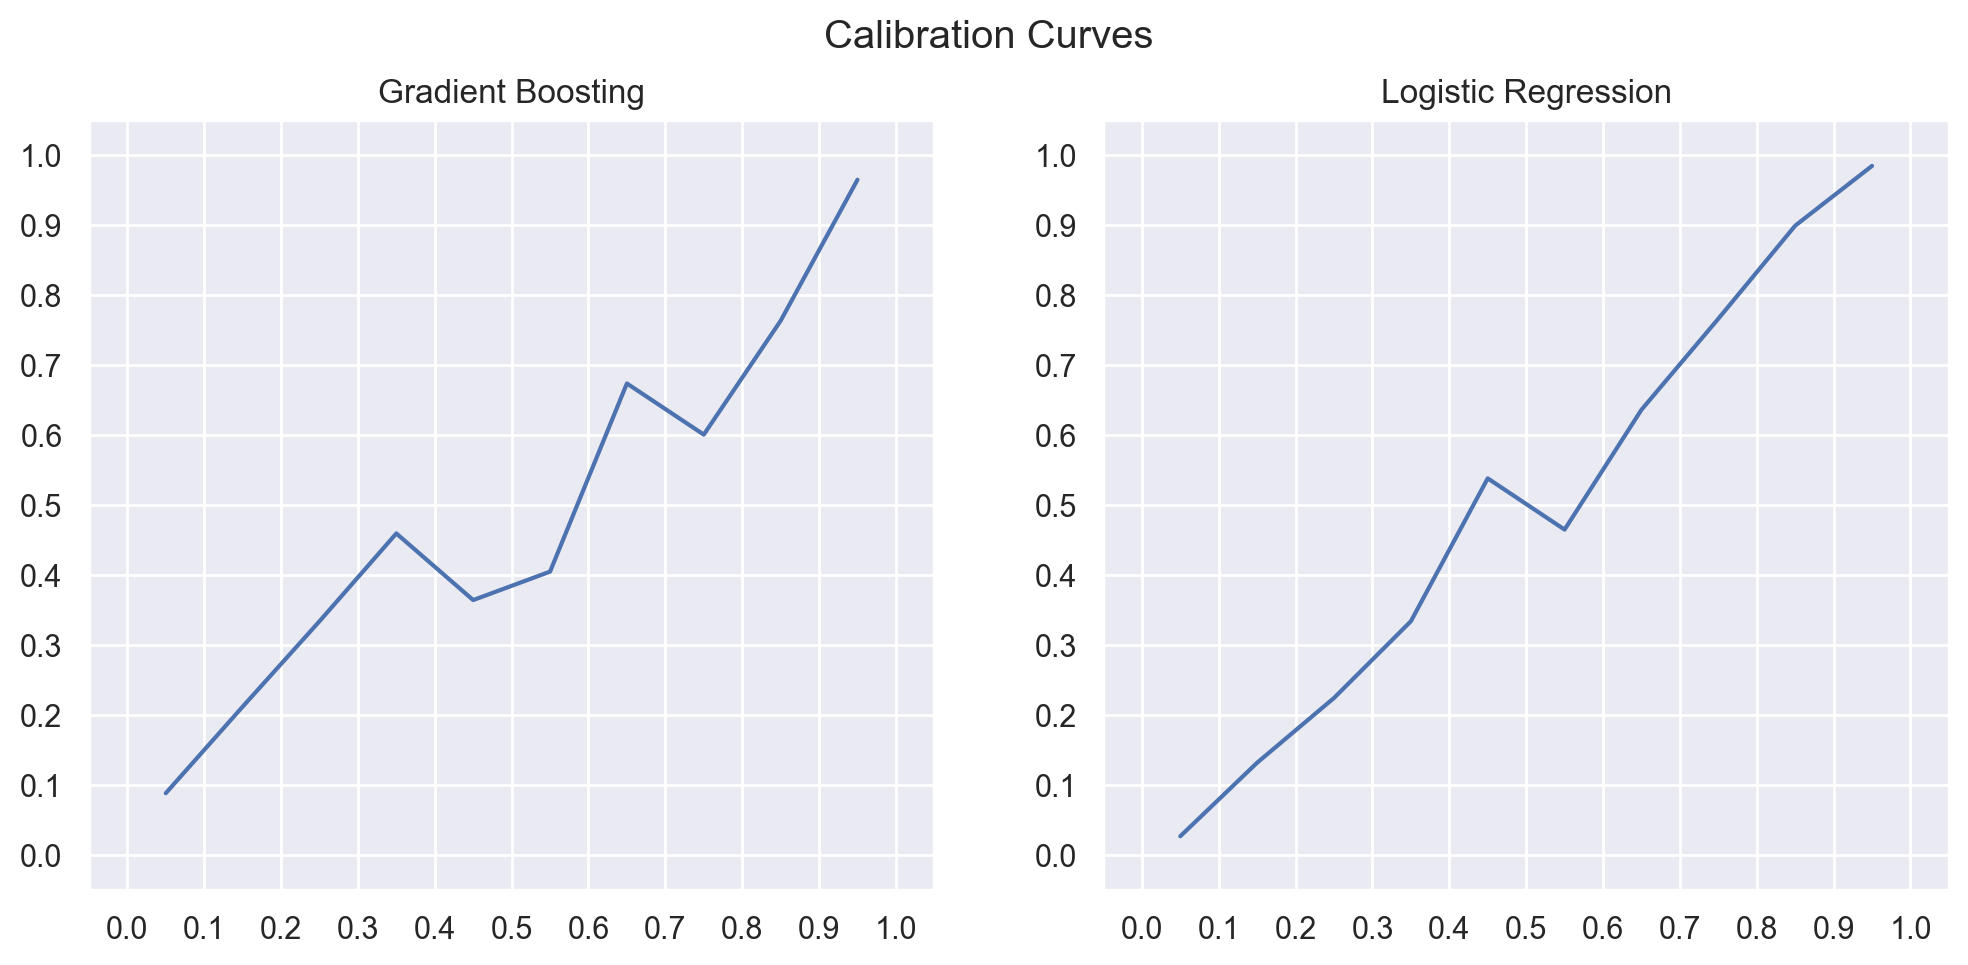

In [ ]:
sns.set(font_scale=1.)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle("Calibration Curves")
ax = axes[0]
ax.set_title("Gradient Boosting")
plot_calibration_curve(y_test, boosting.predict_proba(x_test)[:, 1], ax)
ax = axes[1]
ax.set_title("Logistic Regression")
logreg = LogisticRegression().fit(x_test, y_test)
plot_calibration_curve(y_test, logreg.predict_proba(x_test)[:, 1], ax)

___Ответ___: Видно, что калибровочная кривая у логистической регрессии ближе к диагонали, чем у бустинга, что значит, что бустинг хуже оценивает вероятности. С другой стороны, бывает ещё хуже (как мы видели в дз-4 с SVM), и поэтому можно сказать, что бустинг оценивает вероятности нормально.

Теперь попробуем оценить важность признаков для бустинга.

Поскольку наша базовая модель - это дерево из `sklearn`, мы можем вычислить важность признака отдельно для каждого дерева и усреднить (воспользуйтесь `feature_importances_` у `DecisionTreeRegressor`), после этого нормировать значения, чтобы они суммировались в единицу (обратите внимание, что они должны быть неотрицательными - иначе вы что-то сделали не так).

Допишите в вашей реализации бустинга функцию `feature_importances_` чтобы она возвращала описанные выше важности признаков.

Нарисуйте столбчатую диаграмму важности признаков. На соседнем графике нарисуйте важность признаков для логистической регрессии, для этого используйте модули весов. Сравните графики. Проанализируйте полученные результаты.

Text(0.5, 1.0, 'Logistic Regression')

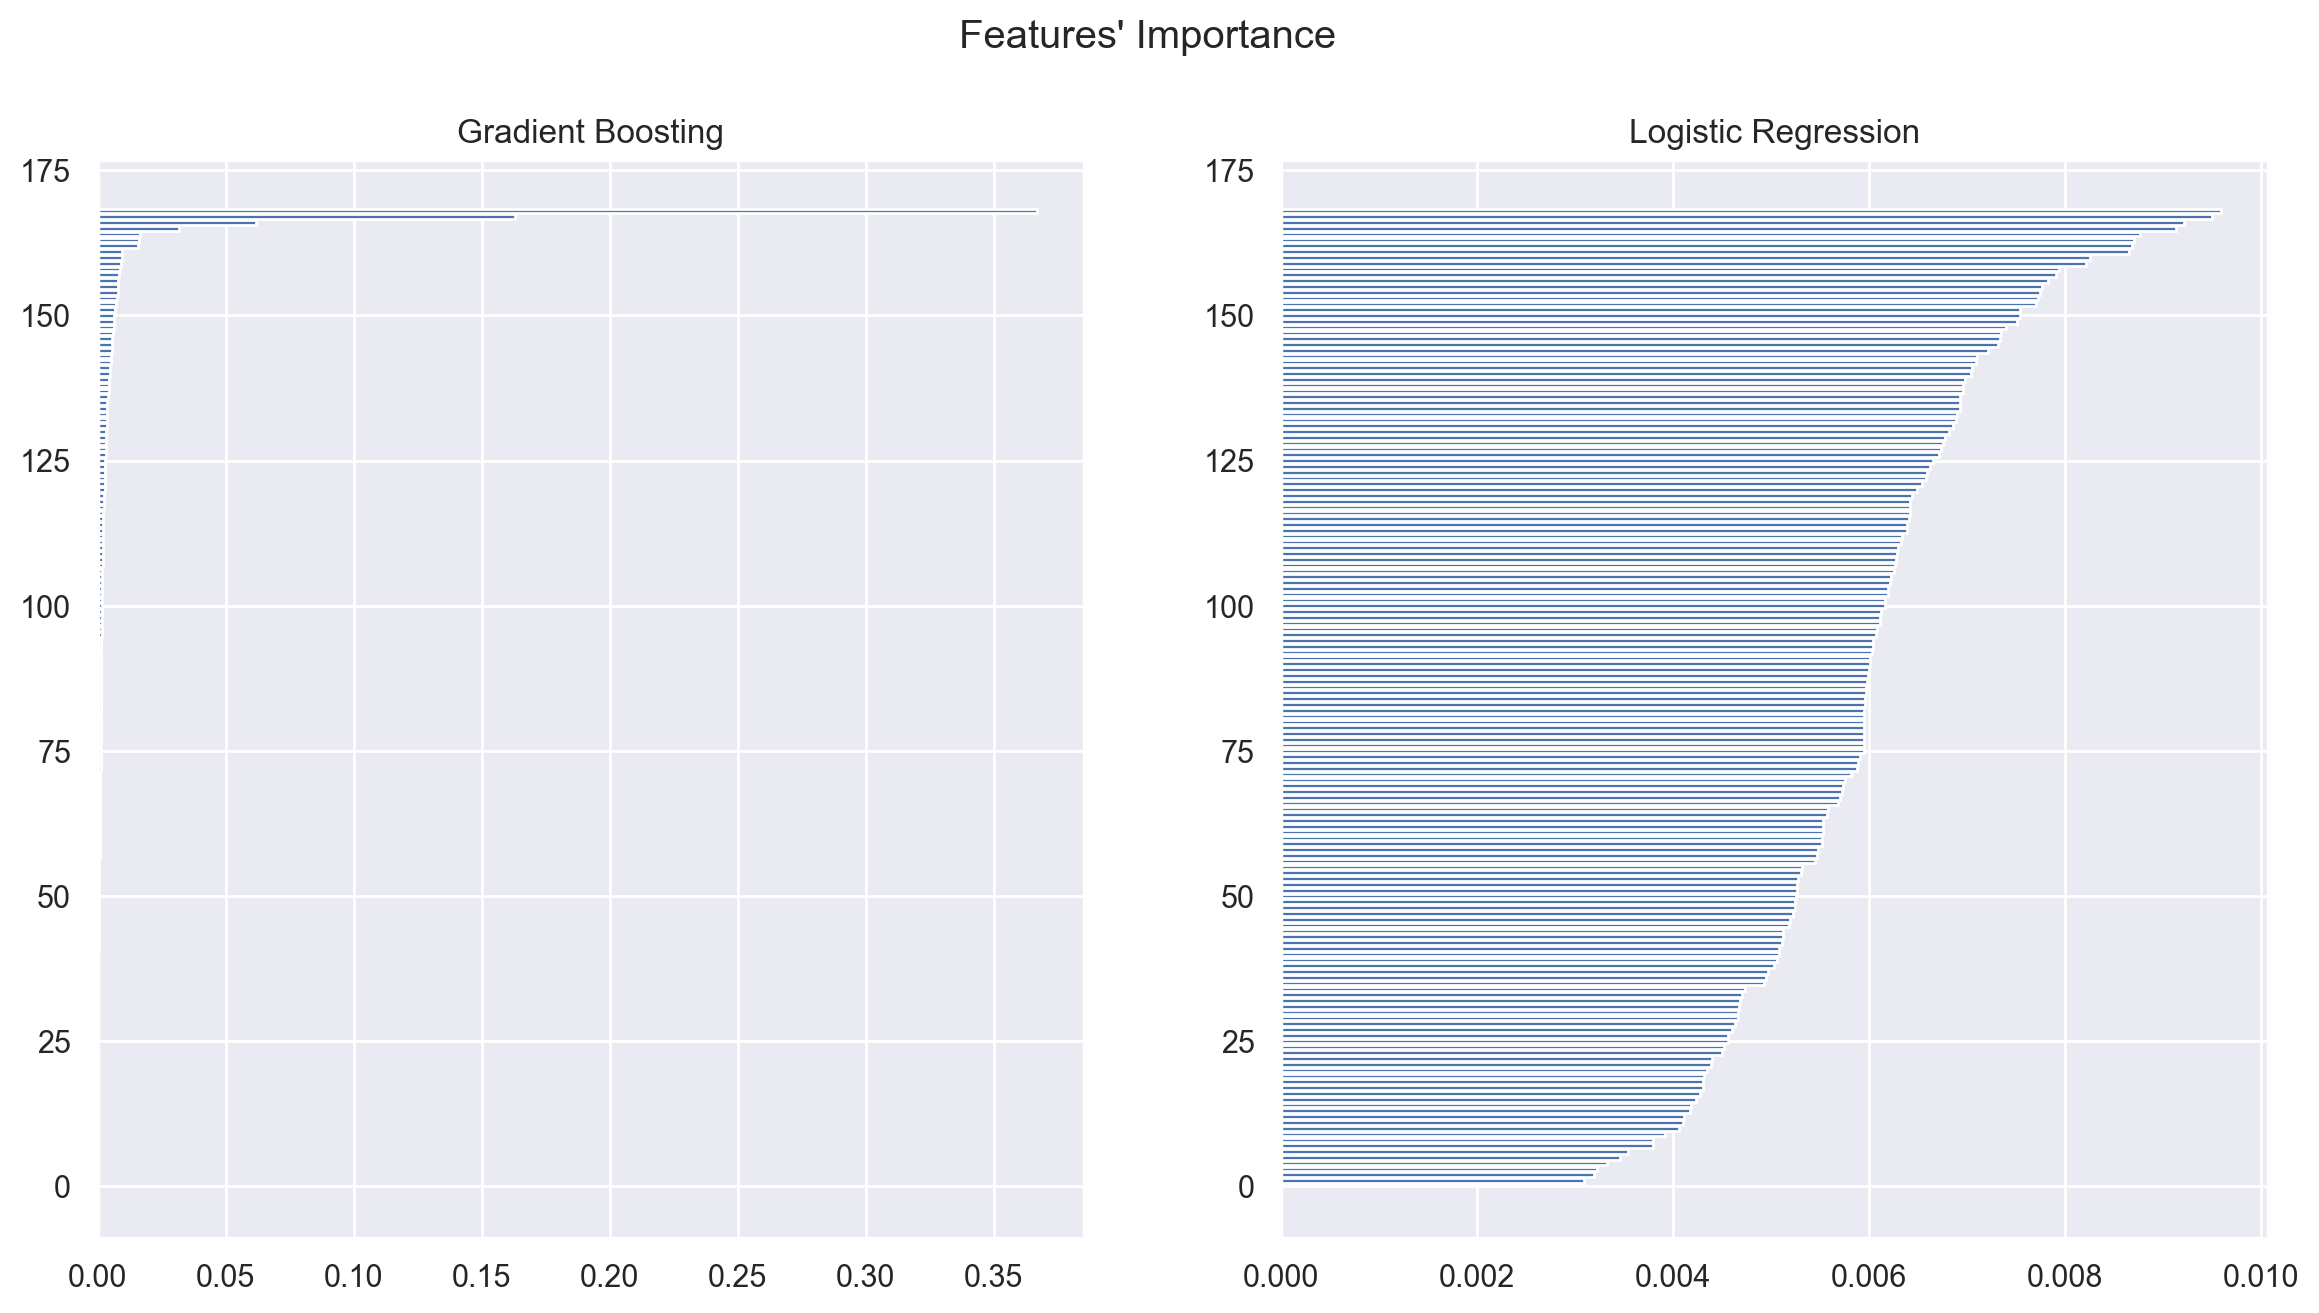

In [ ]:
bfi_s = np.sort(boosting.feature_importances_)
lc = logreg.coef_[0]
lc = (lc - np.min(lc)) / np.sum(lc - np.min(lc))
lc_s = np.sort(lc)

sns.set(font_scale=1.)
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
fig.suptitle("Features' Importance")
ax = axes[0]
ax.barh(np.arange(x.shape[1]), bfi_s)
ax.set_title("Gradient Boosting")
ax = axes[1]
ax.barh(np.arange(x.shape[1]), lc_s)
ax.set_title("Logistic Regression")

Кстати, чаще всего излишние признаки могут вредить качеству бустинга. Попробуйте отфильтровать на основании диаграммы хвост наименее важных признаков и снова обучить модель (с теми же гиперпараметрами). Стало ли лучше?

In [ ]:
i_top_features = (boosting.feature_importances_ > .003)
boosting_top = Boosting(base_model_params=base_model_params, **boosting_params).fit(x_train[:, i_top_features], y_train, x_valid[:, i_top_features], y_valid)

print(f'Number of features: {x.shape[1]}')
print(f'Train AUC-ROC {boosting.score(x_train, y_train):.4f}')
print(f'Val   AUC-ROC {boosting.score(x_valid, y_valid):.4f}')
print(f'Test  AUC-ROC {boosting.score(x_test, y_test):.4f}')
print()
print(f'Number of features: {np.sum(i_top_features)}')
print(f'Train AUC-ROC {boosting_top.score(x_train[:, i_top_features], y_train):.4f}')
print(f'Val   AUC-ROC {boosting_top.score(x_valid[:, i_top_features], y_valid):.4f}')
print(f'Test  AUC-ROC {boosting_top.score(x_test[:, i_top_features], y_test):.4f}')

Number of features: 169
Train AUC-ROC 0.9840
Val   AUC-ROC 0.9428
Test  AUC-ROC 0.9400

Number of features: 43
Train AUC-ROC 0.9821
Val   AUC-ROC 0.9433
Test  AUC-ROC 0.9413


Результаты говорят за себя. В четыре раза меньше признаков и качество выше. Экспериментально я понял, что если брать меньше признаков, качество будет немного хуже (но не более чем на .01).

## Задание 5 (бонус). Блендинговое (1 балл)

Реализуйте блендинг над вашей лучшей моделью и логистической регрессией. Улучшилось ли качество?

## Задание 6 (бонус). Катбустовое (1 балл)

Запустите [CatBoost](https://catboost.ai/en/docs/concepts/python-quickstart) на наших данных, сравните с вашей реализацией. Где получилось лучше?

In [ ]:
best_params

{'max_depth': 6,
 'min_samples_split': 7,
 'min_samples_leaf': 1,
 'n_estimators': 110,
 'learning_rate': 0.6,
 'subsample': 0.8,
 'early_stopping_rounds': 15}

In [ ]:
catboost = CatBoostClassifier(iterations=100, loss_function='Logloss', learning_rate=0.6, subsample=0.8, early_stopping_rounds=15, max_depth=6, min_data_in_leaf=1)
catboost.fit(x_train, y_train)
print(f'Train AUC-ROC {roc_auc_score(y_train, catboost.predict(x_train)):.4f}')
print(f'Test  AUC-ROC {roc_auc_score(y_test, catboost.predict(x_test)):.4f}')

0:	learn: 0.3392059	total: 7.15ms	remaining: 708ms
1:	learn: 0.2857356	total: 14ms	remaining: 684ms
2:	learn: 0.2581590	total: 20ms	remaining: 645ms
3:	learn: 0.2486762	total: 25.8ms	remaining: 620ms
4:	learn: 0.2403460	total: 31.7ms	remaining: 602ms
5:	learn: 0.2336653	total: 37.8ms	remaining: 592ms
6:	learn: 0.2290842	total: 43.6ms	remaining: 579ms
7:	learn: 0.2242832	total: 49.5ms	remaining: 569ms
8:	learn: 0.2214056	total: 55ms	remaining: 556ms
9:	learn: 0.2181023	total: 60.4ms	remaining: 544ms
10:	learn: 0.2141194	total: 66.3ms	remaining: 536ms
11:	learn: 0.2093069	total: 72.8ms	remaining: 534ms
12:	learn: 0.2075413	total: 79.8ms	remaining: 534ms
13:	learn: 0.2058300	total: 85.6ms	remaining: 526ms
14:	learn: 0.2039835	total: 91.6ms	remaining: 519ms
15:	learn: 0.2022651	total: 97.6ms	remaining: 512ms
16:	learn: 0.2007395	total: 104ms	remaining: 507ms
17:	learn: 0.1988053	total: 110ms	remaining: 501ms
18:	learn: 0.1968746	total: 116ms	remaining: 494ms
19:	learn: 0.1952022	total: 215

CatBoost переобучился.

## Социализационный бонус. Новогоднее 🎆 (0.5 балла)

Сфотографируйтесь с наряженной новогодней или рождественской ёлкой! Приложите фотографию, опишите свои впечатления, чего вы ждете от нового 2023 года?

У меня дома ёлкой являюсь я сам, поэтому меня нарядили. А другой ёлки и не нужно. С уважением, дед Мороз.

Хочу чтобы закончился семестр и можно было отдохнуть минут 5-7. От нового года жду быть на 1 больше, чем текущий год. `++year;`

![](https://ucb2310a36fda5b58764d19333cc.previews.dropboxusercontent.com/p/thumb/ABydpWzy3u9LuX4e-3pzV4nnzQIfq1Rr615_3qWdoS9OkoHEtgFUbtoqpdwQOtaw2U40dSm1UZOnLIGEEuwxb_DkWXn_y_vJZVpDqutquR3hT18GRQX7PS2LrjVayHXkE-EFdst40NkRA_y-dGbiXpklxVABVhO-2C2O70ZFtfFJ9jEJXQXaXmiRGzkzPRVycmMnhQkK6v0hyXOk1VjA6u_NaUDLUczdJw2QZSFhPINOpABKOC6cU4fqoL3roc5Vfsg8dvOZBu7wFoG20t_KA9TOKhi6682G3VbUScDGaQB-HKtO22k78OKfSzYQpDdE3IUZmxjX164c6ckKbv-YzWEGG-LxNm4FGW8BOc5D9_ythxWYRTeXqCaRXQ8C-e_-Wuw77WOhB3NMB07k7bytOhqfiTQBVM6MP16JVzQqyFY4FA/p.jpeg)